## Fetch the data

In [37]:
# TODO: add comments and explonations
from sklearn.datasets import fetch_mldata

# get the dataset
mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]

## Draw a random digit from the set

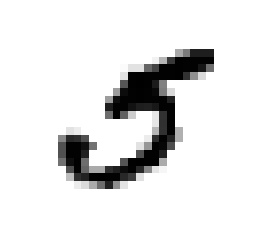

In [38]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# draw some digit
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [39]:
# verify the digit
y[36000]

5.0

## Data Manipulation

In [40]:
# split the sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [41]:
# shuffle the training set
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 5 - Binary Classifier

In [45]:
# 5 classifier
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Stochastic Gradient Descent

In [46]:
# train the Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [47]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

### Manual Cross-Validation

In [48]:
# Cross-validation

# import the libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# define the skfold object
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

# train and fit the models on the folds
# StratifiedKFold performs stratified sampling to produce folds that 
# contains a representative ratio of each class
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9574
0.96475
0.85955


### cross_val_score() -- cross-validation

In [49]:
# using the cross_val_score()
from sklearn.model_selection import cross_val_score

# perform cross validation scoring in 3 validation folds
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([ 0.9574 ,  0.96475,  0.85955])

### Estimator that never guesses 5

In [50]:
from sklearn.base import BaseEstimator

# extend the class
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([ 0.9116 ,  0.9079 ,  0.90945])

### Confusion Matrix

In [51]:
from sklearn.model_selection import cross_val_predict

# predict the values
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [52]:
y_train_pred

array([False, False, False, ..., False, False, False], dtype=bool)

In [53]:
from sklearn.metrics import confusion_matrix

# form the confusion matrix
confusion_matrix(y_train_5, y_train_pred)

array([[51140,  3439],
       [  927,  4494]])

### Precision / Recall

In [54]:
from sklearn.metrics import precision_score, recall_score

# precision and recall
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.566494390521
0.82899833979


### F1 Score

In [55]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.67305676201887077

In [56]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method="decision_function")

In [57]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

### Multiclass Confusion Matrix

In [58]:
from sklearn.metrics import confusion_matrix

# train the models on cross validation
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv = 3)

# build the confusion matrix
conf_mx = confusion_matrix(y_train, y_train_pred)

In [59]:
# check the confusion matrix
conf_mx

array([[5654,    2,   44,   15,    8,   59,   55,    9,   53,   24],
       [   2, 6471,   32,   21,   12,   21,   25,   11,  103,   44],
       [  48,   96, 4895,  267,   53,   44,  182,  116,  199,   58],
       [  23,   34,  266, 4702,   24,  384,   57,   74,  136,  431],
       [  20,   21,   38,   18, 4946,   19,  116,   25,   87,  552],
       [  69,   36,   50,  222,   69, 4351,  151,   50,  238,  185],
       [  29,   15,   49,    9,   14,  118, 5603,    3,   72,    6],
       [  32,   24,   47,   20,   74,    7,   10, 5448,   30,  573],
       [  38,  161,   73,  207,   89,  372,   88,   62, 4312,  449],
       [  34,   27,   26,   65,  183,   65,   10,  246,   69, 5224]])

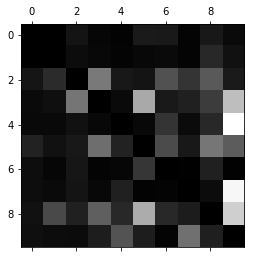

In [60]:
# now we need to normalize the confusion matrix
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

# we now can build the heat map for the confusion matrix
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

### Receiver Operating Characteristic aka ROC

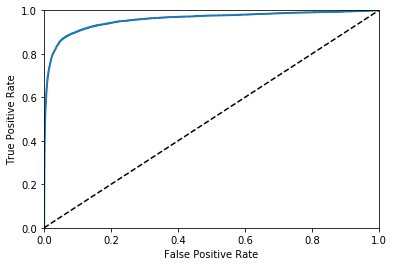

In [24]:
# plot the ROC curve for the SGD Classifier
from sklearn.metrics import roc_curve

# fpr: False Positive Rate, tpr: True Positive Rate
# y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

In [25]:
# check the Area Under the Curve score
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

0.957298427734


In [26]:
# train the random forest model
from sklearn.ensemble import RandomForestClassifier

# initialize the random forest classifier
forest_clf = RandomForestClassifier(random_state = 42)

# train the model
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

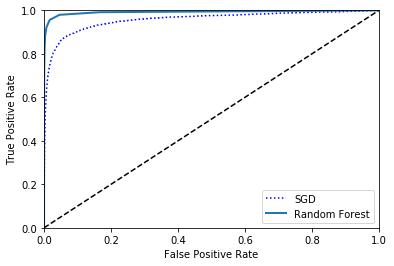

0.992152603005


In [27]:
# get the probabilities of positive class
y_scores_forest = y_probas_forest[:, 1]

# get the false positive, true positive and thresholds for the random forest model
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# plot both curves
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

print(roc_auc_score(y_train_5, y_scores_forest))